<a href="https://colab.research.google.com/github/kiran1442/ColorAugNet/blob/main/Assignment_3_imageColorization_nullClass_without_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import torch
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input,  BatchNormalization
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from skimage.color import rgb2lab, lab2rgb

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.current_device())
else:
  print("No NVDIA driver found. Using cpu")

No NVDIA driver found. Using cpu


In [ ]:
# Load Dataset (Assuming grayscale images and corresponding color images

# def load_dataset():
#     (color_images, _), (_, _) = keras.datasets.cifar10.load_data()
#     color_images = color_images / 255.0  # Normalize

#     lab_images = np.array([rgb2lab(img) for img in color_images])
#     grayscale_images = lab_images[:, :, :, 0:1]  # Extract L channel
#     color_labels = lab_images[:, :, :, 1:]  # Extract ab channels

#     return grayscale_images, color_labels  # Return L as input, ab as labels

# grayscale_images, color_images = load_dataset()

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [ ]:
# Split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(grayscale_images, color_images, test_size=0.2, random_state=42)

In [ ]:
# Convert images to grayscale
# X_train_gray = np.dot(X_train[..., :3], [0.299, 0.587, 0.114]).reshape(-1, 32, 32, 1)
# X_test_gray = np.dot(X_test[..., :3], [0.299, 0.587, 0.114]).reshape(-1, 32, 32, 1)

In [ ]:
# Normalize pixel values
X_train, X_test = X_train / 255.0, X_test / 255.0

In [ ]:
# Convert images to grayscale
X_train_gray = np.dot(X_train[..., :3], [0.299, 0.587, 0.114]).reshape(-1, 32, 32, 1)
X_test_gray = np.dot(X_test[..., :3], [0.299, 0.587, 0.114]).reshape(-1, 32, 32, 1)

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [ ]:
def augment_data(X, num_augmented=2):
    augmented_X = []
    for img in X:
        img = np.expand_dims(img, axis=0)
        aug_iter = datagen.flow(img, batch_size=1)
        for _ in range(num_augmented):
            augmented_img = next(aug_iter)[0]
            augmented_X.append(np.clip(augmented_img, 0, 1))
    return np.array(augmented_X, dtype=np.float32)

In [ ]:
# Apply augmentation
aug_X_train = augment_data(X_train[:5000])
X_train_augmented = np.concatenate([X_train, aug_X_train])

# Convert augmented images to grayscale
aug_X_train_gray = np.dot(aug_X_train[..., :3], [0.299, 0.587, 0.114]).reshape(-1, 32, 32, 1)
X_train_augmented_gray = np.concatenate([X_train_gray, aug_X_train_gray])

In [ ]:
def display_images(original, grayscale, augmented, predictions_original):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(4):
        axes[i, 0].imshow(original[i])
        axes[i, 0].axis('off')
        axes[i, 1].imshow(grayscale[i].squeeze(), cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 2].imshow(augmented[i])
        axes[i, 2].axis('off')
        axes[i, 3].imshow(predictions_original[i])
        axes[i, 3].axis('off')
        # axes[i, 4].imshow(predictions_augmented[i])
        # axes[i, 4].axis('off')
    plt.show()

In [ ]:
# Define a More Complex Colorization Model
def build_colorization_model():
    inputs = Input(shape=(32, 32, 1))
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    # Remove or adjust Upsampling layers to maintain output shape (32, 32, 3)
    # x = UpSampling2D((2, 2))(x)
    # x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    # x = UpSampling2D((2, 2))(x)
    # x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)  # Output layer
    model = Model(inputs, x)
    return model

In [ ]:
# Define a better loss function (SSIM + MSE hybrid loss)
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# def hybrid_loss(y_true, y_pred):
#     mse_loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
#     return mse_loss + ssim_loss(y_true, y_pred)

In [ ]:
# from tensorflow.keras.losses import Huber
model = build_colorization_model()
model.compile(optimizer='adam', loss=ssim_loss, metrics=['mae','accuracy'])

In [ ]:
# Train model without augmentation
history_original = model.fit(X_train_gray, X_train, validation_data=(X_test_gray, X_test), epochs=5)

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4111s 3s/step - accuracy: 0.4281 - loss: 0.0966 - mae: 0.0706 - val_accuracy: 0.4481 - val_loss: 0.0685 - val_mae: 0.0546
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4151s 3s/step - accuracy: 0.4670 - loss: 0.0664 - mae: 0.0567 - val_accuracy: 0.4680 - val_loss: 0.0639 - val_mae: 0.0535
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4090s 3s/step - accuracy: 0.4701 - loss: 0.0643 - mae: 0.0564 - val_accuracy: 0.4634 - val_loss: 0.0638 - val_mae: 0.0526
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3977s 3s/step - accuracy: 0.4689 - loss: 0.0631 - mae: 0.0537 - val_accuracy: 0.4758 - val_loss: 0.0617 - val_mae: 0.0511
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3972s 3s/step - accuracy: 0.4698 - loss: 0.0624 - mae: 0.0526 - val_accuracy: 0.4616 - val_loss: 0.0617 - val_mae: 0.0516


In [ ]:
# Predict on test set without augmentation
predictions_original = model.predict(X_test_gray[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


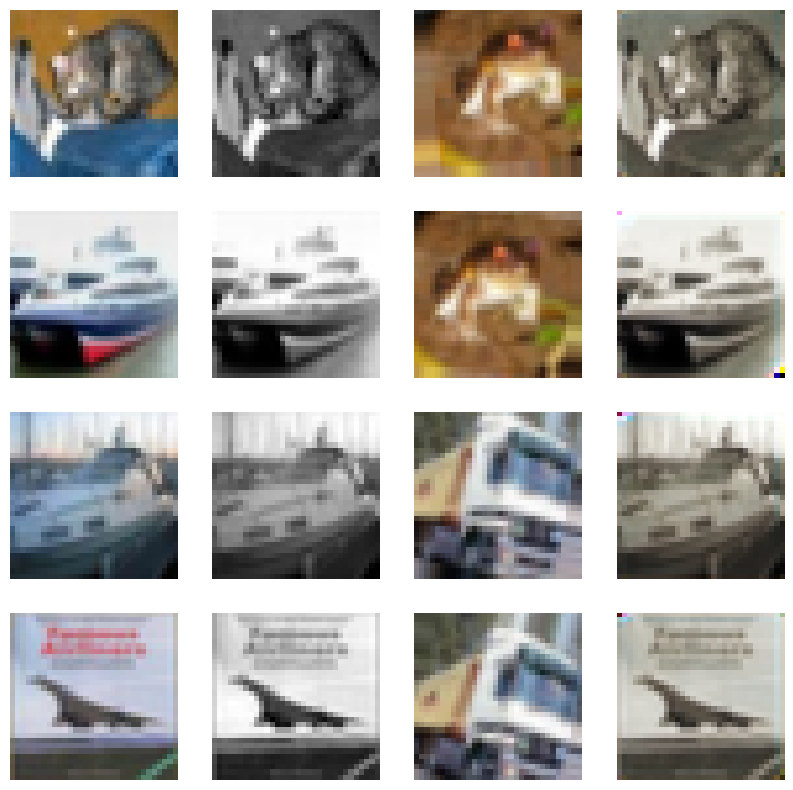

In [ ]:
# Display results
display_images(X_test[:5], X_test_gray[:5], aug_X_train[:5], predictions_original)

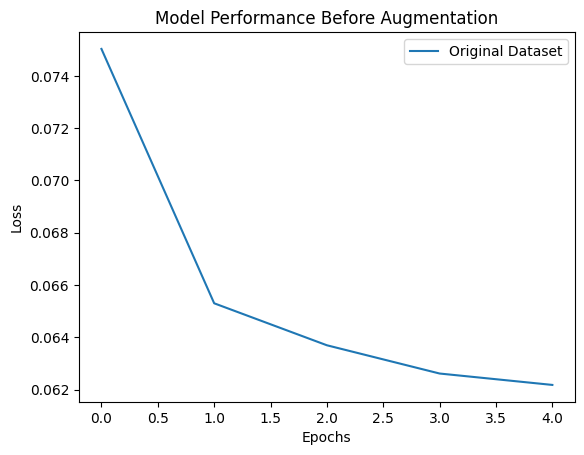

In [ ]:
# Compare performance
plt.plot(history_original.history['loss'], label='Original Dataset')
# plt.plot(history_augmented.history['loss'], label='Augmented Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Performance Before Augmentation')
plt.show()

In [ ]:
from skimage.metrics import structural_similarity as ssim
# Evaluate model performance using SSIM
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    total_ssim = 0
    for i in range(len(X_test)):
        original = y_test[i]
        predicted = predictions[i]

        # Convert images to grayscale for SSIM comparison
        # Convert original and predicted images to uint8 before color conversion
        original_gray = cv2.cvtColor(original.astype(np.uint8), cv2.COLOR_RGB2GRAY)
        predicted_gray = cv2.cvtColor(predicted.astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Compute SSIM
        ssim_score = ssim(original_gray, predicted_gray)
        total_ssim += ssim_score

    avg_ssim = total_ssim / len(X_test)
    print(f"Average SSIM Score: {avg_ssim:.4f}")

In [ ]:
print("Performance before augmentation:")
evaluate_model(model, X_test_gray, X_test)

Performance before augmentation:
313/313 ━━━━━━━━━━━━━━━━━━━━ 167s 535ms/step
Average SSIM Score: 0.9995
